In [57]:
# import required libraries
import pandas as pd
import numpy as np
import shutil
import os
from PIL import Image
import imagehash 
import re
import random
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import plotly.express    as px
from sklearn.utils       import resample

from tensorflow import keras
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from io import BytesIO
from zipfile import ZipFile
from PIL import Image

# Loading the scrapped data from DermNet.


In [17]:
# load and preview dataset
image_df = pd.read_csv('../data/data1-294.csv')
print(image_df.shape)
image_df.head()

(13992, 2)


skin_disorder_name  \
0  acne affecting the back images   
1  acne affecting the back images   
2  acne affecting the back images   
3  acne affecting the back images   
4  acne affecting the back images   

                                              images  
0  https://dermnetnz.org/assets/Uploads/acne/acne...  
1  https://dermnetnz.org/assets/Uploads/acne/acne...  
2  https://dermnetnz.org/assets/Uploads/acne/acne...  
3  https://dermnetnz.org/assets/Uploads/acne/acne...  
4  https://dermnetnz.org/assets/Uploads/acne/acne...

In [43]:
image_df[image_df.duplicated()].shape[0]

42

# Acne
### Meaning
**Acne** is a common skin condition that occurs when hair follicles become clogged with oil and dead skin cells. This leads to the formation of pimples, blackheads, whiteheads, and sometimes deeper cysts. Acne usually appears on the face, neck, chest, back, and shoulders, and can affect people of all ages, although it is most common during puberty.

### Causes
The causes of acne are multifactorial and can include hormonal imbalances, genetics, stress, certain medications, and an overproduction of sebum, the oily substance that lubricates the skin. Certain factors such as diet and hygiene practices have also been implicated in the development of acne, although the evidence for these is less clear.

### Symptoms
The symptoms of acne can vary depending on the severity of the condition. Mild acne may only present with a few blackheads or whiteheads, while moderate acne can involve a combination of pimples, blackheads, and whiteheads. Severe acne may include deep, painful cysts that can lead to scarring. Acne can also have a significant impact on a person's self-esteem and mental health, particularly if it is severe or persistent.

### Treatment
Treatment options for acne depend on the severity of the condition. Mild acne can often be managed with over-the-counter topical treatments that contain benzoyl peroxide or salicylic acid. These products work by reducing the amount of oil on the skin and unclogging pores. More severe acne may require prescription medications, such as topical retinoids or oral antibiotics, which can help to reduce inflammation and kill the bacteria that cause acne. In cases of severe, persistent acne, isotretinoin, a powerful oral medication, may be prescribed. Additionally, lifestyle modifications such as maintaining good hygiene practices, avoiding certain foods, and managing stress can also be helpful in managing acne.


<ul>
    <li>Create a folder for Acne</li>
</ui>

In [19]:
# Labels representing acne in DermNet's scrapped data
acne_labels = list(image_df[image_df['skin_disorder_name'].str.contains('acne')]['skin_disorder_name'].unique())

# removing acne labels whose images will not be used because there are not clear
# acne_labels.remove('infantile acne images')
# acne_labels.remove('steroid acne images')

acne_labels

['acne affecting the back images',
 'acne affecting the face images',
 'acne and other follicular disorder images',
 'facial acne images',
 'infantile acne images',
 'steroid acne images']

In [24]:
# Labels representing eczema in Dermnet's scraped data.
eczema_labels = image_df[(image_df['skin_disorder_name'].str.contains('eczema')) | \
                         (image_df['skin_disorder_name'].str.contains('atopic dermatitis images')) |\
                         (image_df['skin_disorder_name'].str.contains('hand dermatitis images')) |\
                         (image_df['skin_disorder_name'] == 'dermatitis images') |\
                         (image_df['skin_disorder_name'].str.contains('nummular dermatitis images'))] \
                         ['skin_disorder_name'].unique()

eczema_labels

array(['atopic dermatitis images', 'atopic eczema images',
       'atopic flexural eczema images', 'dermatitis images',
       'discoid eczema images', 'eczema herpeticum images',
       'hand dermatitis images', 'nummular dermatitis images'],
      dtype=object)

# create a new column that define acne

In [36]:
image_df['image_label'] = np.where(image_df['skin_disorder_name'].str.contains('acne'),'acne',\
                                  np.where((image_df['skin_disorder_name'].str.contains('eczema')) | \
                         (image_df['skin_disorder_name'].str.contains('atopic dermatitis images')) |\
                         (image_df['skin_disorder_name'].str.contains('hand dermatitis images')) |\
                         (image_df['skin_disorder_name'] == 'dermatitis images') |\
                         (image_df['skin_disorder_name'].str.contains('nummular dermatitis images')),'eczema', \
                         np.where(image_df['skin_disorder_name'].str.contains('keratosis'),'keratosis',
                        np.where(image_df['skin_disorder_name'].str.contains('melanoma'),'melanoma',
                        np.where(image_df['skin_disorder_name'].str.contains('psoriasis'),'psoriasis',
                        np.where(image_df['skin_disorder_name'].str.contains('tinea'),'tinea',''))))))

In [67]:
image_df['image_name'] = image_df['images'].apply(lambda x: x.split('/')[-1])

In [68]:
image_df.head()

skin_disorder_name  \
0  acne affecting the back images   
1  acne affecting the back images   
2  acne affecting the back images   
3  acne affecting the back images   
4  acne affecting the back images   

                                              images image_label  \
0  https://dermnetnz.org/assets/Uploads/acne/acne...        acne   
1  https://dermnetnz.org/assets/Uploads/acne/acne...        acne   
2  https://dermnetnz.org/assets/Uploads/acne/acne...        acne   
3  https://dermnetnz.org/assets/Uploads/acne/acne...        acne   
4  https://dermnetnz.org/assets/Uploads/acne/acne...        acne   

                                          image_name  
0  141__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...  
1  142__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...  
2  143__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...  
3  144__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...  
4  146__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...

In [37]:
image_df['image_label'].value_counts()

image_label
             11039
acne           718
eczema         631
keratosis      567
psoriasis      522
melanoma       469
tinea           46
Name: count, dtype: int64

In [48]:
pd.DataFrame(image_df[image_df['image_label'] == ""]['skin_disorder_name'].value_counts()).head(50)

count
skin_disorder_name                                     
lesion, tumour and cancer images                    502
reactions to external agent images                  450
viral skin infections images                        342
scaly skin disease images                           334
skin signs of systemic disease images               301
disease relating to site or age images              301
hair, scalp, nail and sweat images                  289
procedures images                                   225
deep dermal disorder images                         204
immunological disorder images                       177
bacteria images                                     155
bacterial skin infection images                     155
hand foot and mouth disease images                  152
enteroviral infection images                        152
in situ squamous cell carcinoma images              144
treatment images                                    124
cutaneous lupus erythematosus images                122
sjs-ten images                                      113
hidradenitis suppurativa images                     103
vitiligo images                                     101
dermoscopy course images                             95
scabies images                                       91
palmoplantar pustulosis images                       90
besnier prurigo images                               89
dermatomyositis images                               88
arthropod bites images                               87
insect, mite and worm bite images                    87
keloid images                                        87
pigmentation problem images                          83
syphilis images                                      82
fungal skin infection images                         81
basal cell epithelioma affecting the face images     79
bcc affecting the face images                        79
basalioma affecting the face images                  79
rodent ulcer affecting the face images               79
basal cell carcinoma affecting the face images       79
vulval lichen sclerosus images                       77
rosacea images                                       75
lichen planus images                                 74
solar lentigo images                                 72
epiloia images                                       70
herpes simplex images                                70
lichen planus nail images                            69
autoimmune alopecia images                           61
schamberg disease images                             61
pigmented purpura images                             61
capillaritis images                                  61
lichen aureus images                                 61
pigmented purpuric lichenoid dermatosis images       61
purpura annularis telangiectodes images              61

In [81]:
for i in image_df[image_df['image_label'] == 'acne']['skin_disorder_name'].unique():
    print(i.split('/')[-1])

acne affecting the back images
acne affecting the face images
acne and other follicular disorder images
facial acne images
infantile acne images
steroid acne images


# load data from URL and add those image in Acne folder

In [56]:
for url in image_df[image_df['image_label'] == 'acne']['images']:
    pic_name = url.split('/')[-1]
    
    img_data = requests.get(url).content
    with open(f'../data/image/acne/{pic_name}', 'wb') as handler:
        handler.write(img_data)

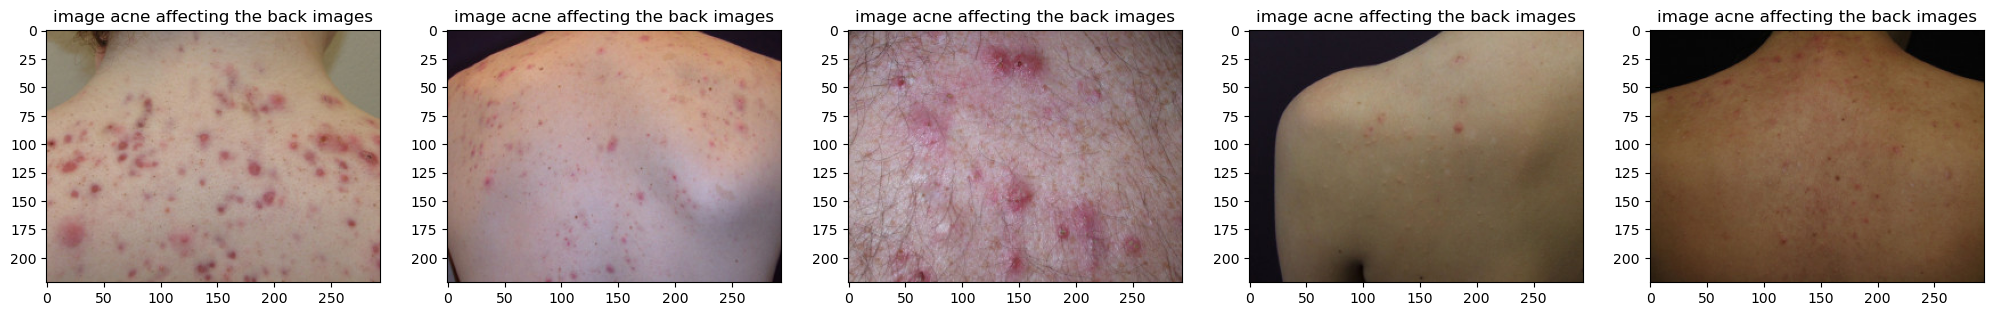

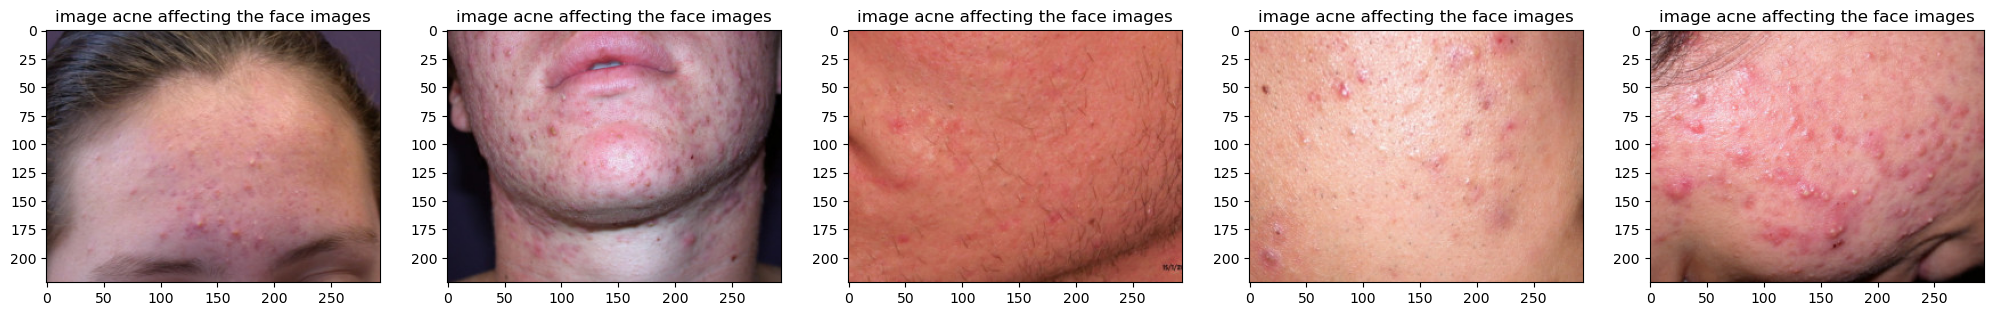

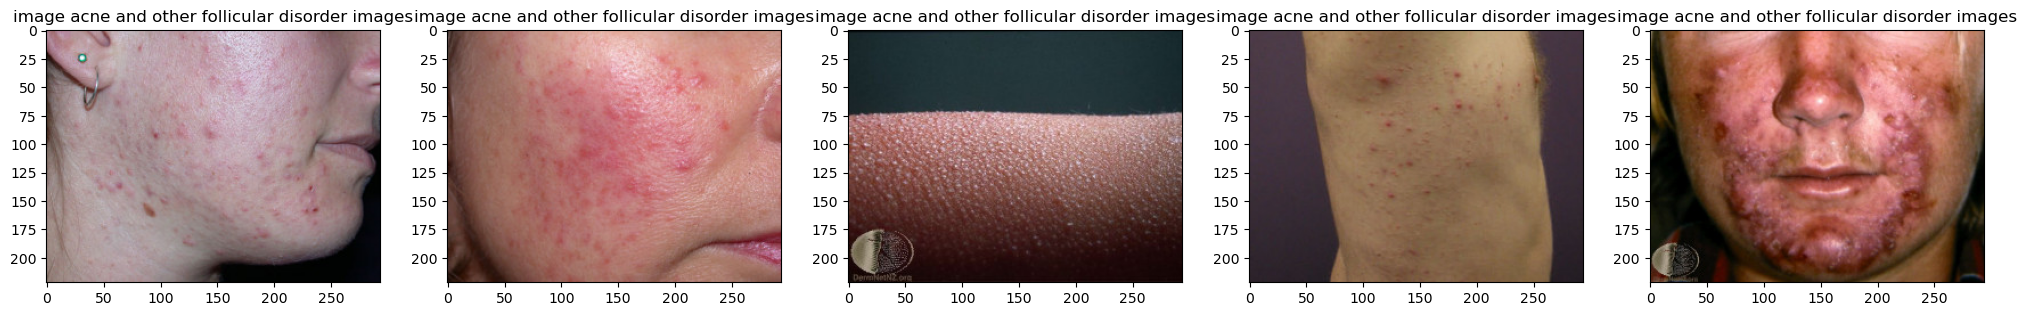

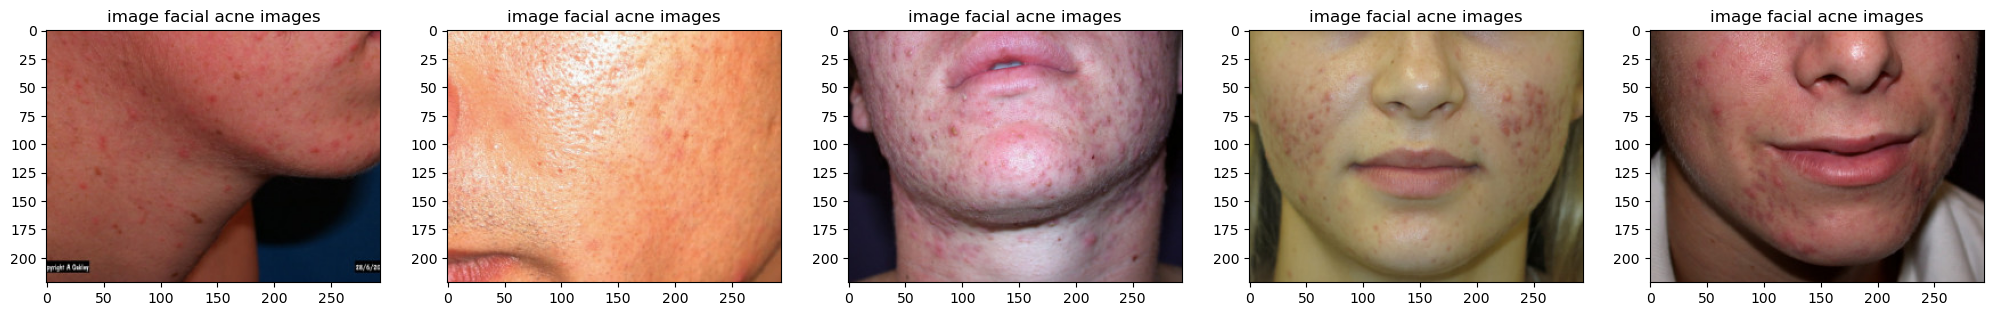

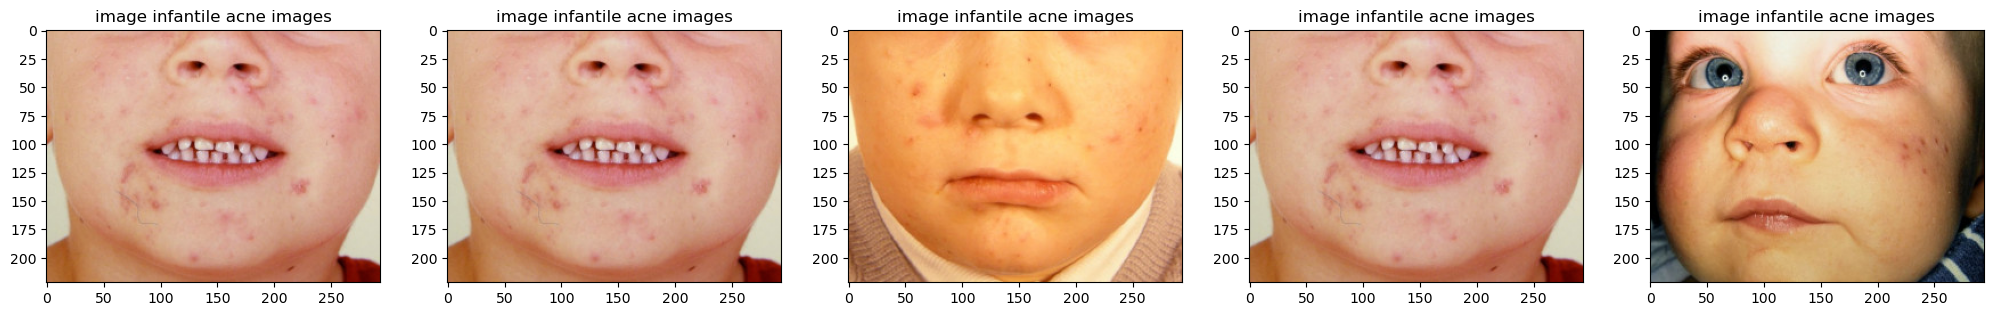

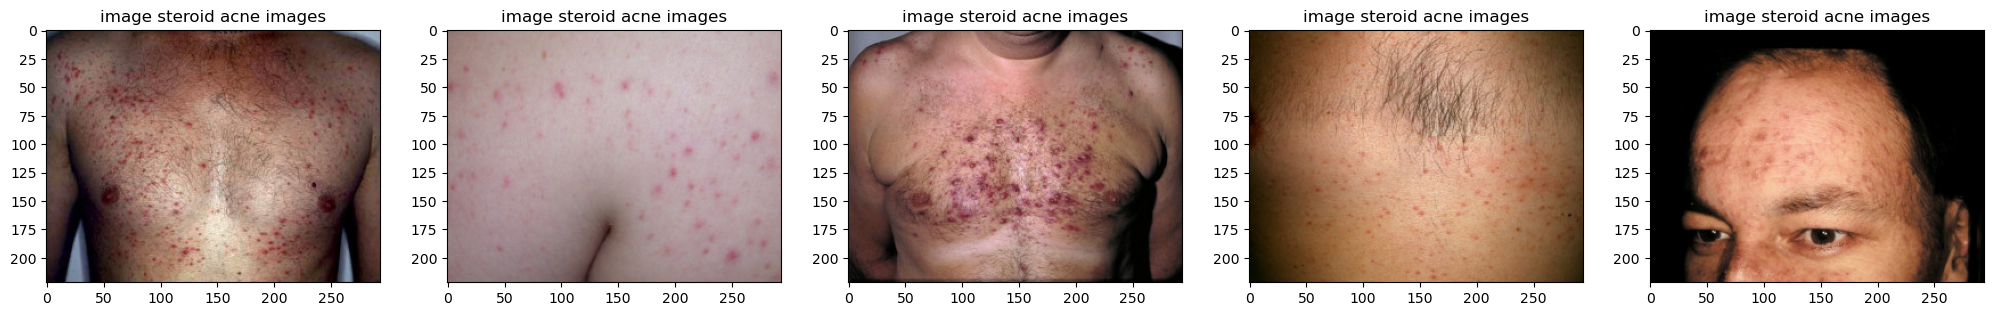

In [104]:
def get_images(diagnosis):
    fig, ax = plt.subplots(1,5,figsize=(25, 25))
    for i in range(5):
        with ZipFile('../data/image/acne.zip', 'r') as zfile:
            image_index = random.choice(image_df[image_df['image_label'] == 'acne']\
                                        [image_df[image_df['image_label'] == 'acne']['skin_disorder_name'] == diagnosis]\
                                        ['image_name'].reset_index(drop=True))
            data = zfile.read(f'acne/{image_index}')
            processedImg = Image.open(BytesIO(data))
            ax[i].set_title(f'image {diagnosis}')
            ax[i].imshow(processedImg)

for name_diagnosis in image_df[image_df['image_label'] == 'acne']['skin_disorder_name'].unique():
    get_images(name_diagnosis)